<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import time
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import nst_utils
import numpy as np
import tensorflow as tf

%matplotlib inline


In [2]:
model = nst_utils.load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")

print(model)


{'input': <tf.Variable 'Variable:0' shape=(1, 300, 400, 3) dtype=float32_ref>, 'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 300, 400, 64) dtype=float32>, 'conv1_2': <tf.Tensor 'Relu_1:0' shape=(1, 300, 400, 64) dtype=float32>, 'avgpool1': <tf.Tensor 'AvgPool:0' shape=(1, 150, 200, 64) dtype=float32>, 'conv2_1': <tf.Tensor 'Relu_2:0' shape=(1, 150, 200, 128) dtype=float32>, 'conv2_2': <tf.Tensor 'Relu_3:0' shape=(1, 150, 200, 128) dtype=float32>, 'avgpool2': <tf.Tensor 'AvgPool_1:0' shape=(1, 75, 100, 128) dtype=float32>, 'conv3_1': <tf.Tensor 'Relu_4:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_3': <tf.Tensor 'Relu_6:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_4': <tf.Tensor 'Relu_7:0' shape=(1, 75, 100, 256) dtype=float32>, 'avgpool3': <tf.Tensor 'AvgPool_2:0' shape=(1, 38, 50, 256) dtype=float32>, 'conv4_1': <tf.Tensor 'Relu_8:0' shape=(1, 38, 50, 512) dtype=float32>, 'conv4_2': <tf.Tensor 'Relu_9:0' shap

In [4]:
#tf.assign函数用法
model["input"].assign(image)


TypeError: Expected float32 passed to parameter 'value' of op 'Assign', got <module 'PIL.Image' from 'D:\\Program Files (x86)\\Anaconda3\\envs\\tf1\\lib\\site-packages\\PIL\\Image.py'> of type 'module' instead.

In [5]:
sess.run(model["conv4_2"])

NameError: name 'sess' is not defined

In [6]:
def compute_content_cost(a_C, a_G):
    """
    计算内容代价的函数
    
    参数：
        a_C -- tensor类型，维度为(1, n_H, n_W, n_C)，表示隐藏层中图像C的内容的激活值。
        a_G -- tensor类型，维度为(1, n_H, n_W, n_C)，表示隐藏层中图像G的内容的激活值。
    
    返回：
        J_content -- 实数，用上面的公式1计算的值。
        
    """
    
    #获取a_G的维度信息
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    #对a_C与a_G从3维降到2维
    a_C_unrolled = tf.transpose(tf.reshape(a_C, [n_H * n_W, n_C]))
    a_G_unrolled = tf.transpose(tf.reshape(a_G, [n_H * n_W, n_C]))
    
    #计算内容代价
    #J_content = (1 / (4 * n_H * n_W * n_C)) * tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled, a_G_unrolled)))
    J_content = 1/(4*n_H*n_W*n_C)*tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled, a_G_unrolled)))
    return J_content


In [7]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_C = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_content = compute_content_cost(a_C, a_G)
    print("J_content = " + str(J_content.eval()))
    
    test.close()


J_content = 6.7655935


D:\Program Files (x86)\Anaconda3\envs\tf1\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


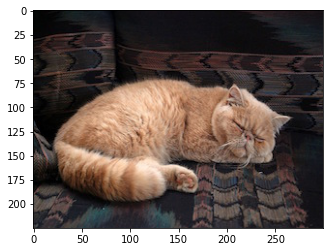

In [9]:
style_image = scipy.misc.imread("images/persian_cat_content.jpg")

imshow(style_image)


In [10]:
def gram_matrix(A):
 
    GA = tf.matmul(A, tf.transpose(A))
 
    return GA

In [11]:
tf.reset_default_graph()
 
with tf.Session() as test:
    tf.set_random_seed(1)
    A = tf.random_normal([3, 2*1], mean=1, stddev=4)
    GA = gram_matrix(A)
 
    print("GA = " + str(GA.eval()))

GA = [[ 6.422305 -4.429122 -2.096682]
 [-4.429122 19.465837 19.563871]
 [-2.096682 19.563871 20.686462]]


In [12]:
def compute_layer_style_cost(a_S, a_G):
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
 
    a_S = tf.transpose(tf.reshape(a_S, [n_H*n_W, n_C]))
    a_G = tf.transpose(tf.reshape(a_G, [n_H*n_W, n_C]))
    
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)
    
    J_style_layer = 1. / (4 * n_C * n_C * n_H * n_H * n_W * n_W) * \
                    tf.reduce_sum(tf.square(tf.subtract(GS, GG)))
 
    return J_style_layer

In [13]:
tf.reset_default_graph()
 
with tf.Session() as test:
    tf.set_random_seed(1)
    a_S = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_style_layer = compute_layer_style_cost(a_S, a_G)
 
    print("J_style_layer = " + str(J_style_layer.eval()))

J_style_layer = 9.190278


In [14]:
STYLE_LAYERS = [('conv1_1', 0.2),
                ('conv2_1', 0.2),
                ('conv3_1', 0.2),
                ('conv4_1', 0.2),
                ('conv5_1', 0.2)]

In [15]:
def compute_style_cost(model, STYLE_LAYERS):
 
    J_style = 0
    for layer_name, coeff in STYLE_LAYERS:
 
        out = model[layer_name]
        a_S = sess.run(out)
        a_G = out
 
        J_style_layer = compute_layer_style_cost(a_S, a_G)
 
        J_style += coeff * J_style_layer
 
    return J_style

In [16]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
 
    J = alpha * J_content + beta * J_style
 
    return J

In [17]:
tf.reset_default_graph()
 
with tf.Session() as test:
    np.random.seed(3)
    J_content = np.random.randn()    
    J_style = np.random.randn()
    J = total_cost(J_content, J_style)
    print("J = " + str(J))

J = 35.34667875478276


In [18]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [21]:
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")

NameError: name 'load_vgg_model' is not defined

In [22]:
sess.run(model['input'].assign(content_image))
out = model['conv4_2']
a_C = sess.run(out)
a_G = out
J_content = compute_content_cost(a_C, a_G)
 
sess.run(model['input'].assign(style_image))
J_style = compute_style_cost(model, STYLE_LAYERS)
 
J = total_cost(J_content, J_style, 10, 40)
 
optimizer = tf.train.AdamOptimizer(2.0)
train_step = optimizer.minimize(J)

ValueError: Shapes must be equal rank, but are 4 and 3 for 'Assign_1' (op: 'Assign') with input shapes: [1,300,400,3], [300,400,3].